<a href="https://colab.research.google.com/github/NeyoxDrago/Object-Detection-Work/blob/main/Skin%20Lesions/skin_lesion_semantic_segmentation_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## link to datasets and references 
# https://github.com/zhixuhao/unet/blob/master/model.py
# https://challenge.isic-archive.com/data

# [1] Noel Codella, Veronica Rotemberg, Philipp Tschandl, M. Emre Celebi, Stephen Dusza, David Gutman, Brian Helba, Aadi Kalloo, Konstantinos Liopyris, Michael Marchetti, Harald Kittler, Allan Halpern: “Skin Lesion Analysis Toward Melanoma Detection 2018: A Challenge Hosted by the International Skin Imaging Collaboration (ISIC)”, 2018; https://arxiv.org/abs/1902.03368

# [2] Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018).


In [1]:
!wget --header="Host: isic-challenge-data.s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.101 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip" -c -O 'ISIC2018_Task1-2_Training_Input.zip'
!unzip -q ISIC2018_Task1-2_Training_Input.zip

--2020-12-21 09:16:25--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.96.172
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.96.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11165358566 (10G) [application/zip]
Saving to: ‘ISIC2018_Task1-2_Training_Input.zip’

ISIC2018_Task1-2_Tr 100%[===================>]  10.40G  35.4MB/s    in 4m 9s   

2020-12-21 09:20:34 (42.7 MB/s) - ‘ISIC2018_Task1-2_Training_Input.zip’ saved [11165358566/11165358566]



In [2]:
!wget --header="Host: isic-challenge-data.s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.101 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip" -c -O 'ISIC2018_Task1_Training_GroundTruth.zip'
!unzip -q ISIC2018_Task1_Training_GroundTruth.zip

--2020-12-21 09:26:09--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.49.154
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.49.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27402895 (26M) [application/zip]
Saving to: ‘ISIC2018_Task1_Training_GroundTruth.zip’

ISIC2018_Task1_Trai 100%[===================>]  26.13M  74.0MB/s    in 0.4s    

2020-12-21 09:26:10 (74.0 MB/s) - ‘ISIC2018_Task1_Training_GroundTruth.zip’ saved [27402895/27402895]



In [1]:
import os
len(os.listdir("ISIC2018_Task1-2_Training_Input/")) , len(os.listdir("ISIC2018_Task1_Training_GroundTruth/"))

(2596, 2596)

In [2]:
import cv2
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
import random

In [3]:
image_path = "ISIC2018_Task1-2_Training_Input"
mask_path = "ISIC2018_Task1_Training_GroundTruth"

all_images = os.listdir(image_path)
all_images = [i for i in all_images if not i.endswith("txt")]
all_images_mask = os.listdir(mask_path)
all_images_mask = [i for i in all_images_mask if not i.endswith("txt")]

In [4]:
random.sample(all_images,4)

['ISIC_0003308.jpg',
 'ISIC_0000490.jpg',
 'ISIC_0015215.jpg',
 'ISIC_0015417.jpg']

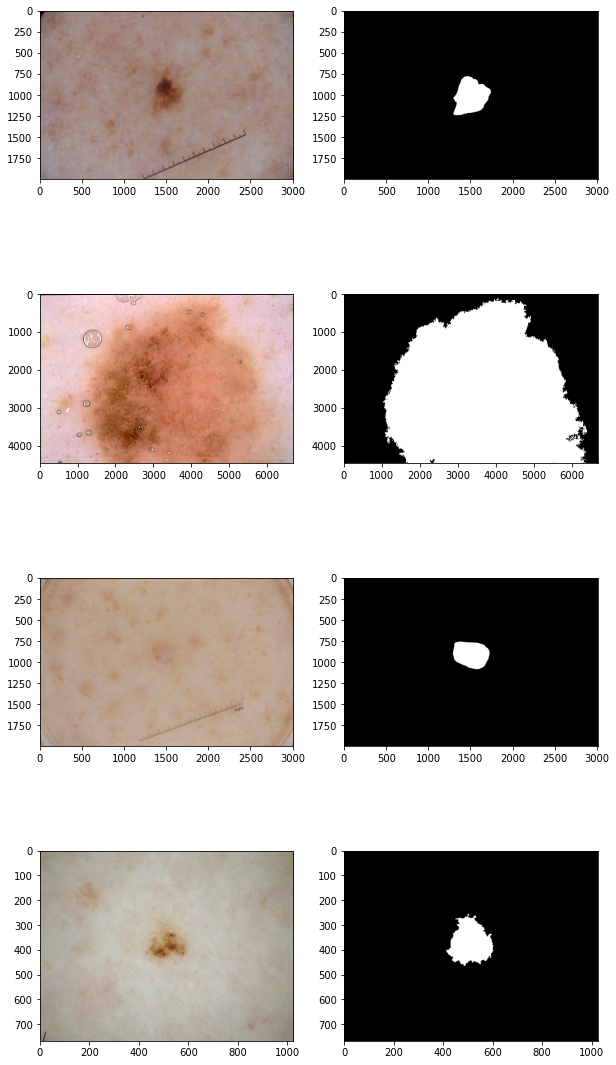

In [5]:
fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(10,20))

for c,i in enumerate(random.sample(all_images,4)):
  sample_image = cv2.imread(os.path.join(image_path,i))
  sample_mask = cv2.imread(os.path.join(mask_path,i.split(".")[0]+"_segmentation.png"))

  sample_image = cv2.cvtColor(sample_image , cv2.COLOR_BGR2RGB)
  ax[c][0].imshow(sample_image)
  ax[c][1].imshow(sample_mask)
  
plt.show()

In [7]:
print(sample_image.shape,sample_mask.shape)
# m = cv2.cvtColor(sample_mask,cv2.COLOR_BGR2GRAY)
# print(m.reshape((*m.shape,1)).shape)
from google.colab.patches import cv2_imshow
# cv2_imshow(m)
# m.shape

(768, 1024, 3) (768, 1024, 3)


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import *
import tensorflow_addons as tfa

In [52]:
def build_model(input_shape):
  inputs = Input(shape=input_shape)
  conv1 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(inputs)
  conv1 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(conv1)
  conv1 = BatchNormalization()(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(pool1)
  conv2 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(conv2)
  conv2 = BatchNormalization()(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(pool2)
  conv3 = Conv2D(256, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(conv3)
  conv3 = BatchNormalization()(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(pool3)
  conv4 = Conv2D(512, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(conv4)
  conv4 = BatchNormalization()(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(pool4)
  conv5 = Conv2D(1024, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(conv5)
  conv5 = BatchNormalization()(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(merge6)
  conv6 = Conv2D(512, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(conv6)
  conv6 = BatchNormalization()(conv6)
  
  up7 = Conv2D(256, 2, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(merge7)
  conv7 = Conv2D(256, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(conv7)
  conv7 = BatchNormalization()(conv7)
  
  up8 = Conv2D(128, 2, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(merge8)
  conv8 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(conv8)
  conv8 = BatchNormalization()(conv8)
  
  up9 = Conv2D(64, 2, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(merge9)
  conv9 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(conv9)
  conv9 = Conv2D(2, 3, activation = 'elu', padding = 'same', kernel_initializer = tf.keras.initializers.GlorotUniform(),trainable=True)(conv9)
 
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = tf.keras.models.Model(inputs= inputs, outputs= conv10)

  return model

# tf.keras.utils.plot_model(build_model((224,224,3)),show_shapes=True,dpi=70)

In [14]:
from sklearn.model_selection import train_test_split
training_data_x,testing_data_x  = train_test_split([i for i in os.listdir(image_path) if not i.endswith(".txt")],test_size=0.2,shuffle=True)
training_data_y = [f'{i.split(".")[0]}_segmentation.png' for i in training_data_x]
testing_data_y  = [f'{i.split(".")[0]}_segmentation.png' for i in testing_data_x]

In [15]:
import albumentations as A
augment = A.Compose([A.HorizontalFlip(p=0.6),
                     A.VerticalFlip(p=0.7),
                    #  A.RandomScale(scale_limit=0.2,interpolation=cv2.INTER_AREA),
                    #  A.Cutout(num_holes = 15,max_h_size=16,max_w_size=16)
                    ],
                    additional_targets={
                        "image":"image",
                        "mask":'image'
                    })

In [16]:
import gc
gc.collect()

0

(768, 1024)
(768, 1024, 1)


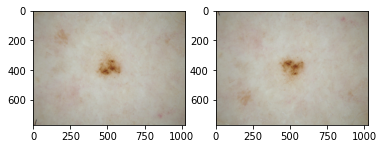

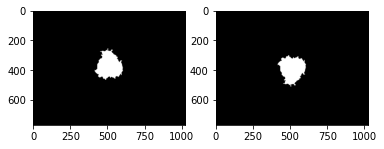

In [17]:
m = cv2.cvtColor(sample_mask,cv2.COLOR_BGR2GRAY)
print(m.shape)
m=  np.expand_dims(m,axis = 2)
t = augment(image=sample_image,mask=m)
im = t['image']
m = t['mask']

fig,ax = plt.subplots(1,2)
ax[0].imshow(sample_image)
ax[1].imshow(im)

fig,ax = plt.subplots(1,2)
ax[0].imshow(sample_mask)
print(m.shape)
m = cv2.cvtColor(m.reshape((*m.shape[:2])),cv2.COLOR_GRAY2BGR)
ax[1].imshow(m)

In [57]:
import gc
from tensorflow.keras.preprocessing.image import *

class generator(tf.keras.utils.Sequence):
  def __init__(self,
               X_paths, y_paths,
               new_shape = (224,224),
               batch_size= 64,
               task="training"):
    
    self.X_paths = X_paths
    self.y_paths = y_paths
    self.batch_size = batch_size
    self.task = task
    self.new_shape = new_shape
  
  def __len__(self):
    return int(len(self.X_paths)/self.batch_size)
  
  def __getitem__(self,idx):
 
    gc.collect()

    X = self.X_paths[idx*self.batch_size:(idx+1)*self.batch_size]
    y  = self.y_paths[idx*self.batch_size:(idx+1)*self.batch_size]

    X_new = []
    y_new = []

    for image_p,mask_p in list(zip(X,y)):
      
      image = img_to_array(load_img(os.path.join(image_path,image_p),target_size=updated_shape))
      mask = img_to_array(load_img(os.path.join(mask_path,mask_p),target_size=updated_shape))

      t = augment(image=image,mask=mask)
      i = t['image']
      m = t['mask']

      m = cv2.cvtColor(m,cv2.COLOR_RGB2GRAY)
      m = np.expand_dims(m,axis=2)
      X_new.append(i/255)
      y_new.append(m/255)
    
    del X,y

    from sklearn.utils import shuffle
    X_new,y_new = shuffle(X_new,y_new,random_state=7) 

    return np.asarray(X_new), np.asarray(y_new)

In [113]:
BATCH_SIZE = 32
LR = 0.001
updated_shape=(256,256)

tf.keras.backend.clear_session()

train_gen = generator(training_data_x,training_data_y,
                      new_shape = updated_shape ,batch_size=BATCH_SIZE)

val_gen = generator(testing_data_x,testing_data_y,
                    new_shape = updated_shape ,batch_size=BATCH_SIZE)

print("Loaders Created Successfully.")

model = build_model((*updated_shape,3))

model.compile(loss = "binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(lr=LR),
              metrics = ["acc"])

model.fit(train_gen,
          epochs=10,
          verbose=1,
          shuffle=True,
          validation_data=val_gen,
          callbacks=[tf.keras.callbacks.ModelCheckpoint('model.h5')])

Loaders Created Successfully.
Epoch 1/10
64/64 [==============================] - 730s 11s/step - loss: 0.4332 - acc: 0.7933 - val_loss: 1.0853 - val_acc: 0.8225
Epoch 2/10
64/64 [==============================] - 736s 11s/step - loss: 0.2938 - acc: 0.8834 - val_loss: 0.8216 - val_acc: 0.8374
Epoch 3/10
64/64 [==============================] - 746s 12s/step - loss: 0.2470 - acc: 0.9030 - val_loss: 0.6947 - val_acc: 0.8808
Epoch 4/10
64/64 [==============================] - 725s 11s/step - loss: 0.2246 - acc: 0.9120 - val_loss: 1.3120 - val_acc: 0.8259
Epoch 5/10
64/64 [==============================] - 733s 11s/step - loss: 0.2115 - acc: 0.9190 - val_loss: 0.9329 - val_acc: 0.8456
Epoch 6/10
64/64 [==============================] - 740s 12s/step - loss: 0.1966 - acc: 0.9223 - val_loss: 0.3903 - val_acc: 0.8599
Epoch 7/10
64/64 [==============================] - 738s 11s/step - loss: 0.2043 - acc: 0.9211 - val_loss: 0.3537 - val_acc: 0.8973
Epoch 8/10
64/64 [============================

Image Path ISIC2018_Task1-2_Training_Input/ISIC_0015645.jpg
1/1 [==============================] - 0s 31ms/step
Mask Path ISIC2018_Task1_Training_GroundTruth/ISIC_0015645_segmentation.png


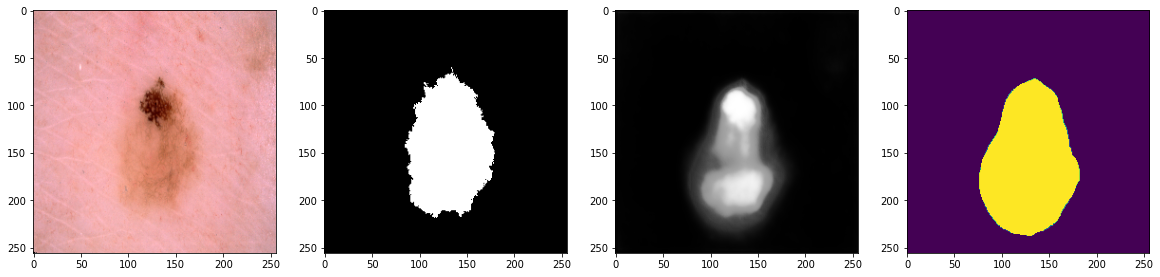

In [142]:
sample_im  = random.sample(all_images,1)
path = os.path.join(image_path,sample_im[0])
print(f"Image Path {path}")
img = img_to_array(load_img(path,target_size=updated_shape),dtype=np.int)
prediction = model.predict(np.expand_dims(img/255,axis=0),verbose=1)[0]
# print(prediction.shape)

fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))
ax[0].imshow(img)

path = os.path.join(mask_path,sample_im[0].split(".")[0]+"_segmentation.png")
print(f"Mask Path {path}")
mask = img_to_array(load_img(path,target_size=updated_shape),dtype=np.int)
ax[1].imshow(mask)


pred = prediction.reshape((256,256))
# pred = np.asarray(pred,dtype=int)
ax[2].imshow(pred,cmap="gray")

m = pred
m = np.where(m<m.mean(),0,255)
ax[3].imshow(m)

plt.show()